# Table of Contents
 <p><div class="lev3 toc-item"><a href="#Based-on-the-following-notebooks" data-toc-modified-id="Based-on-the-following-notebooks-001"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>Based on the following notebooks</a></div><div class="lev3 toc-item"><a href="#Load-input-data" data-toc-modified-id="Load-input-data-002"><span class="toc-item-num">0.0.2&nbsp;&nbsp;</span>Load input data</a></div><div class="lev3 toc-item"><a href="#Merge-DFs" data-toc-modified-id="Merge-DFs-003"><span class="toc-item-num">0.0.3&nbsp;&nbsp;</span>Merge DFs</a></div><div class="lev3 toc-item"><a href="#Clean-data" data-toc-modified-id="Clean-data-004"><span class="toc-item-num">0.0.4&nbsp;&nbsp;</span>Clean data</a></div><div class="lev4 toc-item"><a href="#TODO:-bd-in-members" data-toc-modified-id="TODO:-bd-in-members-0041"><span class="toc-item-num">0.0.4.1&nbsp;&nbsp;</span>TODO: bd in members</a></div><div class="lev3 toc-item"><a href="#Add-features" data-toc-modified-id="Add-features-005"><span class="toc-item-num">0.0.5&nbsp;&nbsp;</span>Add features</a></div><div class="lev3 toc-item"><a href="#Split-train-and-validation-set" data-toc-modified-id="Split-train-and-validation-set-006"><span class="toc-item-num">0.0.6&nbsp;&nbsp;</span>Split train and validation set</a></div>

### Based on the following notebooks

https://www.kaggle.com/asmitavikas/feature-engineered-0-68310

https://www.kaggle.com/vinnsvinay/introduction-to-boosting-using-lgbm-lb-0-68357

https://www.kaggle.com/kamilkk/i-have-to-say-this

Python 2.7
Pandas 0.19

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime
import math
import gc


In [ ]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

### Load input data

In [2]:
data_path = '../input/'
# really? msno, song_id etc. as category?
train = pd.read_csv(data_path + 'train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv(data_path + 'test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
# Fix songs list https://www.kaggle.com/alexklibisz/songs-csv-quote-errors-cause-513-missing-songs
songs = pd.read_csv(data_path + 'songs.fixed.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv(data_path + 'members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')

### Merge DFs

In [5]:
train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')


test = test.merge(songs_extra, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')

### Clean data
#### TODO: bd in members

### Add features

In [6]:
def genre_id_count(x):
    if x == 'no_genre_id':
        return 0
    else:
        return x.count('|') + 1

train['genre_ids'].fillna('no_genre_id',inplace=True)
test['genre_ids'].fillna('no_genre_id',inplace=True)
train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count).astype(np.int8)

def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

train['lyricist'].fillna('no_lyricist',inplace=True)
test['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)
test['lyricists_count'] = test['lyricist'].apply(lyricist_count).astype(np.int8)

def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['composer'].fillna('no_composer',inplace=True)
test['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)
test['composer_count'] = test['composer'].apply(composer_count).astype(np.int8)

def is_featured(x):
    if 'feat' in str(x) :
        return 1
    return 0

train['artist_name'].fillna('no_artist',inplace=True)
test['artist_name'].fillna('no_artist',inplace=True)
# train['is_featured'] = train['artist_name'].apply(is_featured).astype(np.int8)
# test['is_featured'] = test['artist_name'].apply(is_featured).astype(np.int8)

def artist_count(x):
    if x == '佚名':
        return 0
    if x == '群星' or x == 'Various Artists':
        return -1
    return sum(map(x.count, ['|', ',', 'feat', '&', 'and'])) + 1

train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
test['artist_count'] = test['artist_name'].apply(artist_count).astype(np.int8)

# # if artist is same as composer
# train['artist_composer'] = (train['artist_name'] == train['composer']).astype(np.int8)
# test['artist_composer'] = (test['artist_name'] == test['composer']).astype(np.int8)


# # if artist, lyricist and composer are all three same
# train['artist_composer_lyricist'] = ((train['artist_name'] == train['composer']) & (train['artist_name'] == train['lyricist']) & (train['composer'] == train['lyricist'])).astype(np.int8)
# test['artist_composer_lyricist'] = ((test['artist_name'] == test['composer']) & (test['artist_name'] == test['lyricist']) & (test['composer'] == test['lyricist'])).astype(np.int8)

# is song language 17 or 45. 
def song_lang_boolean(x):
    if '17.0' in str(x) or '45.0' in str(x):
        return 1
    return 0

# train['song_lang_boolean'] = train['language'].apply(song_lang_boolean).astype(np.int8)
# test['song_lang_boolean'] = test['language'].apply(song_lang_boolean).astype(np.int8)


_mean_song_length = np.mean(train['song_length'])
def smaller_song(x):
    if x < _mean_song_length:
        return 1
    return 0

train['smaller_song'] = train['song_length'].apply(smaller_song).astype(np.int8)
test['smaller_song'] = test['song_length'].apply(smaller_song).astype(np.int8)

# number of times a song has been played before
_dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
_dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def count_song_played(x):
    try:
        return _dict_count_song_played_train[x]
    except KeyError:
        try:
            return _dict_count_song_played_test[x]
        except KeyError:
            return 0
    

train['count_song_played'] = train['song_id'].apply(count_song_played).astype(np.int64)
test['count_song_played'] = test['song_id'].apply(count_song_played).astype(np.int64)

# number of times the artist has been played
_dict_count_artist_played_train = {k: v for k, v in train['artist_name'].value_counts().iteritems()}
_dict_count_artist_played_test = {k: v for k, v in test['artist_name'].value_counts().iteritems()}
def count_artist_played(x):
    try:
        return _dict_count_artist_played_train[x]
    except KeyError:
        try:
            return _dict_count_artist_played_test[x]
        except KeyError:
            return 0

train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played).astype(np.int64)

In [15]:
# number of tracks the artist has
_artist_tracks_dict = {k: v for k, v in songs['artist_name'].value_counts().iteritems()}
def count_artist_tracks(artist_name):
    try:
        return _artist_tracks_dict[artist_name]
    except KeyError:
        return 0
train['count_artist_tracks'] = train['artist_name'].apply(count_artist_tracks).astype(np.int64)
test['count_artist_tracks'] = test['artist_name'].apply(count_artist_tracks).astype(np.int64)

In [ ]:
# TODO: one-hot encode genre ids

### Split train and validation set

In [16]:
print ("Train test and validation sets")
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')


from sklearn.model_selection import train_test_split
        
X_train = train.drop(['target'], axis=1)
y_train = train['target'].values

X_test = test.drop(['id'], axis=1)
ids = test['id'].values

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train)

lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_val = lgb.Dataset(X_val, y_val)

Train test and validation sets


In [20]:
params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'learning_rate': 0.2 ,
        'verbose': 5,
        'num_leaves': 256,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'num_rounds': 500,
        'metric' : 'auc'
    }

%time model_f1 = lgb.train(params, train_set = lgb_train, valid_sets = lgb_val, verbose_eval=10)

[10]	valid_0's auc: 0.773714
[20]	valid_0's auc: 0.794913
[30]	valid_0's auc: 0.803622
[40]	valid_0's auc: 0.807703
[50]	valid_0's auc: 0.81042
[60]	valid_0's auc: 0.812379
[70]	valid_0's auc: 0.81348
[80]	valid_0's auc: 0.814659
[90]	valid_0's auc: 0.815347
[100]	valid_0's auc: 0.816398
[110]	valid_0's auc: 0.81739
[120]	valid_0's auc: 0.818176
[130]	valid_0's auc: 0.81875
[140]	valid_0's auc: 0.819339
[150]	valid_0's auc: 0.819795
[160]	valid_0's auc: 0.820232
[170]	valid_0's auc: 0.82053
[180]	valid_0's auc: 0.821099
[190]	valid_0's auc: 0.82147
[200]	valid_0's auc: 0.821835
[210]	valid_0's auc: 0.822178
[220]	valid_0's auc: 0.82253
[230]	valid_0's auc: 0.822999
[240]	valid_0's auc: 0.823377
[250]	valid_0's auc: 0.82359
[260]	valid_0's auc: 0.823866
[270]	valid_0's auc: 0.824088
[280]	valid_0's auc: 0.824252
[290]	valid_0's auc: 0.824526
[300]	valid_0's auc: 0.8247
[310]	valid_0's auc: 0.824938
[320]	valid_0's auc: 0.825137
[330]	valid_0's auc: 0.825283
[340]	valid_0's auc: 0.825458

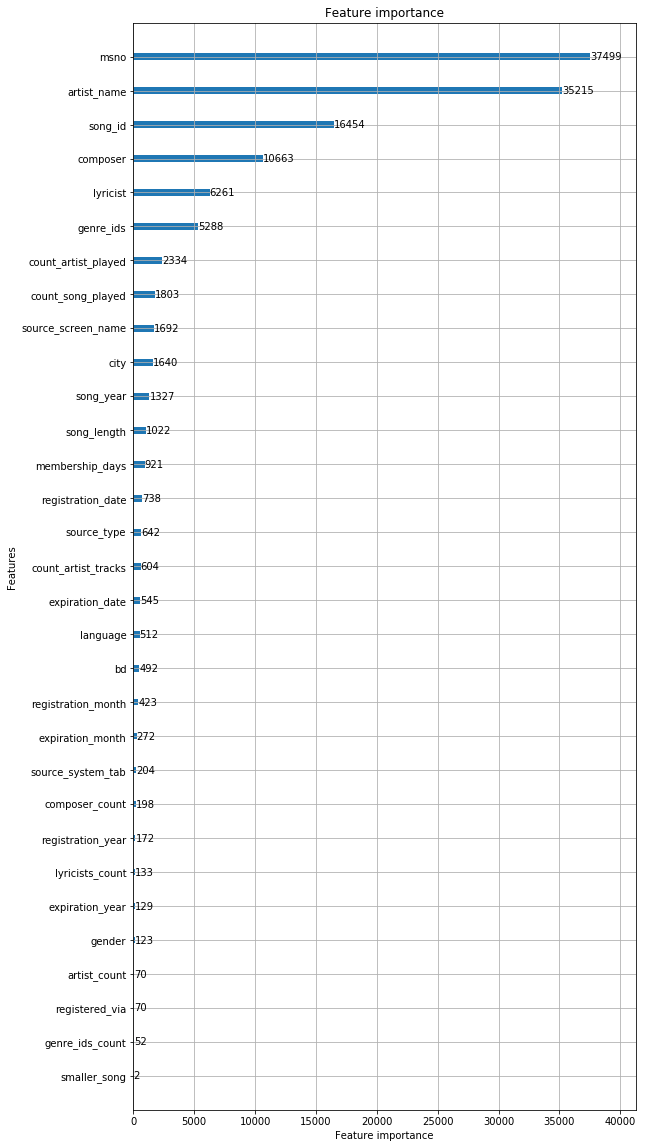

In [21]:
%matplotlib inline
lgb.plot_importance(model_f1, figsize=(9,20))

In [22]:
params = {
        'objective': 'binary',
        'boosting': 'dart',
        'learning_rate': 0.2 ,
        'verbose': 5,
        'num_leaves': 256,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'num_rounds': 300,
        'metric' : 'auc'
    }

%time model_f2 = lgb.train(params, train_set=lgb_train,  valid_sets=lgb_val, verbose_eval=10)

[10]	valid_0's auc: 0.768913
[20]	valid_0's auc: 0.790231
[30]	valid_0's auc: 0.800004
[40]	valid_0's auc: 0.803747
[50]	valid_0's auc: 0.805614
[60]	valid_0's auc: 0.80842
[70]	valid_0's auc: 0.808775
[80]	valid_0's auc: 0.810201
[90]	valid_0's auc: 0.810419
[100]	valid_0's auc: 0.811015
[110]	valid_0's auc: 0.811255
[120]	valid_0's auc: 0.812702
[130]	valid_0's auc: 0.813478
[140]	valid_0's auc: 0.813994
[150]	valid_0's auc: 0.813664
[160]	valid_0's auc: 0.813521
[170]	valid_0's auc: 0.814102
[180]	valid_0's auc: 0.815026
[190]	valid_0's auc: 0.815759
[200]	valid_0's auc: 0.816128
[210]	valid_0's auc: 0.816304
[220]	valid_0's auc: 0.81692
[230]	valid_0's auc: 0.817404
[240]	valid_0's auc: 0.818263
[250]	valid_0's auc: 0.818362
[260]	valid_0's auc: 0.818344
[270]	valid_0's auc: 0.818789
[280]	valid_0's auc: 0.818893
[290]	valid_0's auc: 0.819403
[300]	valid_0's auc: 0.819413
CPU times: user 6h 50min 27s, sys: 1min 22s, total: 6h 51min 49s
Wall time: 59min 4s


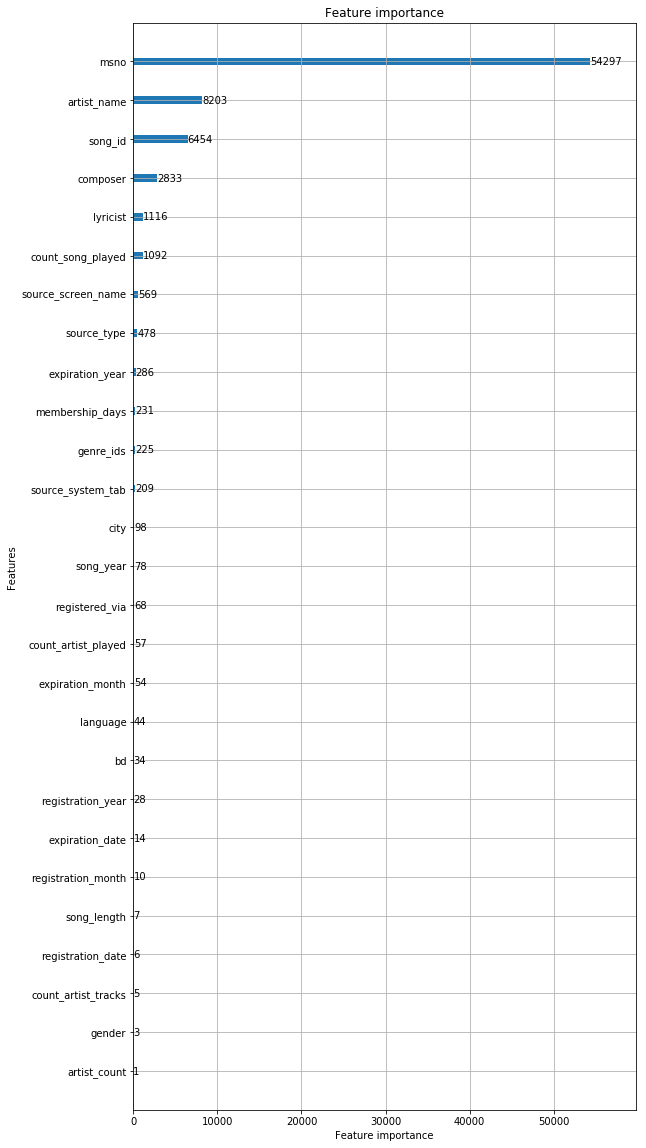

In [23]:
%matplotlib inline
lgb.plot_importance(model_f2, figsize=(9,20))

In [24]:
print('Making predictions')
p_test_1 = model_f1.predict(X_test)
p_test_2 = model_f2.predict(X_test)
p_test_avg = np.mean([p_test_1, p_test_2], axis = 0)


print('Done making predictions')

Making predictions
Done making predictions


In [25]:
print ('Saving predictions Model')

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test_avg
subm.to_csv(data_path + 'submission_lgbm_avg.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')

Saving predictions Model
Done!
